Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Loading data
Data loading: 0.8042070865631104 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Sequence defined
[[-5.5805624e-05 -5.4844702e-05]
 [-1.5417385e-04  8.9366746e-05]
 [-9.7803677e-05 -4.3154010e-05]
 ...
 [-5.9799760e-05 -1.3625912e-06]
 [-3.7759608e-05 -6.5835113e-05]
 [ 6.0702048e-05  5.6239583e-07]]
[[-5.5805624e-05 -5.4844702e-05]
 [-1.5417385e-04  8.9366746e-05]
 [-9.7803677e-05 -4.3154010e-05]
 ...
 [-5.9799760e-05 -1.3625912e-06]
 [-3.7759608e-05 -6.5835113e-05]
 [ 6.0702048e-05  5.6239583e-07]]
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Error!
Execution time: 0.004992246627807617 seconds


c:\Git\hyperbolic-tsne\hyperbolicTSNE\util.py:18: UserWarning: genfromtxt: Empty input file: "temp/poincaregpu/solver_gradient_descent_sequential_opt_0/6, 128.6866600729115.csv"
  return np.genfromtxt(total_file, delimiter=',')
Traceback (most recent call last):
  File "C:\Users\Milan\AppData\Local\Temp\ipykernel_16656\3332527440.py", line 131, in <module>
    hyperbolicEmbedding = htsne.fit_transform((D, V))
  File "c:\Git\hyperbolic-tsne\hyperbolicTSNE\hyperbolic_tsne_.py", line 233, in fit_transform
    X_embedded = self._fit(X)
  File "c:\Git\hyperbolic-tsne\hyperbolicTSNE\hyperbolic_tsne_.py", line 210, in _fit
    self.optimizer = self.opt_method(
  File "c:\Git\hyperbolic-tsne\hyperbolicTSNE\optimizer_.py", line 79, in __init__
    self.cf = self.params["cf"](n_components=self.n_components,
  File "c:\Git\hyperbolic-tsne\hyperbolicTSNE\cost_functions_.py", line 71, in __init__
    self.params = other_params
  File "c:\Git\hyperbolic-tsne\hyperbolicTSNE\cost_functions_.py", line 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

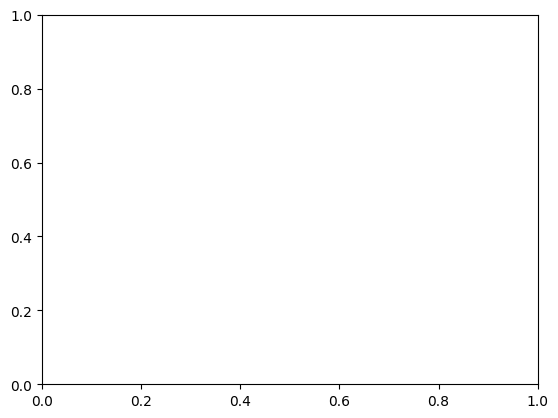

In [1]:
import os
import traceback
import numpy as np
import time
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE

data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.MNIST  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 1000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 15  # we use a perplexity of 30 in this example
logging = False

print("Loading data")

start_time = time.time()

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

end_time = time.time()

execution_time = end_time - start_time
print("Data loading:", execution_time, "seconds")

exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.












# ============= RUNNING EXACT GPU =============







opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=False,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
    uniform_grid_n = 16,
    use_uniform_grid = True
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

# Start: configure logging
if logging:
    logging_dict = {
        "log_path": log_path
    }
    opt_params["logging_dict"] = logging_dict

    log_path = opt_params["logging_dict"]["log_path"]
    # Delete old log path
    if os.path.exists(log_path) and not only_animate:
        import shutil
        shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

start_time = time.time()

try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-inexact.png")









# ============= RUNNING EXACT CPU =============






opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=True,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
    uniform_grid_n = 16,
    use_uniform_grid = True
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

if logging:
    log_path = "temp/poincarecpu/"  # path for saving embedding snapshots

    # Start: configure logging
    logging_dict = {
        "log_path": log_path
    }
    #opt_params["logging_dict"] = logging_dict

    log_path = opt_params["logging_dict"]["log_path"]
    # Delete old log path
    if os.path.exists(log_path) and not only_animate:
        import shutil
        shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

start_time = time.time()

try:
    #hyperbolicEmbedding = htsne.fit_transform((D, V))
    print("would run exact")
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-exact.png")